# Scott Breitbach
## DSC 650, Week 12
## 30-May-2022

## Assignment 12  
Using section 8.4 in *Deep Learning with Python* as a guide, implement a variational autoencoder using the MNIST data set and save a grid of 15 x 15 digits to the `results/vae` directory. If you would rather work on a more interesting dataset, you can use the [CelebFaces Attributes Dataset](https://www.tensorflow.org/datasets/catalog/celeb_a) instead.

### Implement encoder:

In [1]:
# VAE encoder network
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2 # Dimensionality of the latent space: a 2D plane

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# The input image ends up being encoded into these two parameters:
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [2]:
# View summary of encoder
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

Use `z_mean` and `z_log_var` to generate a latent space point z:

In [3]:
# Latent-space-sampling layer
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        # Draw a batch of random normal vectors:
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        # Apply the VAE sampling formula:
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Implement decoder:

In [4]:
# VAE decoder network, mapping latent space points to images
latent_inputs = keras.Input(shape=(latent_dim,)) # Input where we'll feed z
# Produce the same number of coefficients that we 
# had at the level of the Flatten layer in the encoder:
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x) # Revert the Flatten layer of the encoder
# REvert the Conv2D layers of the encoder:
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# The output ends up with shape (28, 28, 1):
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [5]:
# View summary of decoder
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

### Create VAE model:



In [6]:
# VAE model with custom `train_step()`
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        # Use these metrics to keep track of the loss averages over each epoch
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    # List the metrics in the metrics property to enable the model to reset
    # them after each epoch (or between multiple calls to fit()/evaluate()):
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            # Sum the reconstruction loss over the spatial dimensions
            # (axes 1 and 2) and take its mean over the batch dimension:
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # Add the regularization term (Kullback-Leibler divergence):
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Instantiate and train the model on MNIST digits:

In [7]:
# Training the VAE
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
# We train on all MNIST digits, so we concatenate the training/test samples:
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
# Note: we don't pass loss argument in compile(), bc loss is in train_step():
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
# Note: we don't pass targets in fit(), bc train_step() doesn't expect any:
vae.fit(mnist_digits, epochs=30, batch_size=128)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 31s 34ms/step - total_loss: 213.1618 - reconstruction_loss: 211.5648 - kl_loss: 1.5971
Epoch 2/30
547/547 [==============================] - 18s 33ms/step - total_loss: 187.9043 - reconstruction_loss: 185.8839 - kl_loss: 2.0203
Epoch 3/30
547/547 [==============================] - 18s 33ms/step - total_loss: 180.6431 - reconstruction_loss: 178.3032 - kl_loss: 2.3397
Epoch 4/30
547/547 [==============================] - 20s 36ms/step - total_loss: 164.6951 - reconstruction_loss: 161.1611 - kl_loss: 3.5339
Epoch 5/30
547/547 [==============================] - 18s 33ms/step - total_loss: 159.6920 - reconstruction_loss: 156.0002 - kl_loss: 3.6917
Epoch 6/30
547/547 [==============================] - 19s 35ms/step - total_loss: 157.2526 - reconstruction_loss: 153.5374 - kl_loss: 3.7151
Epoch 7/30
547/547 [==============================] - 19s 34ms/step - total_loss: 155.671

### Make a 30x30 grid of digits:
Use the `decoder` network to turn arbitrary latent space vectors into images

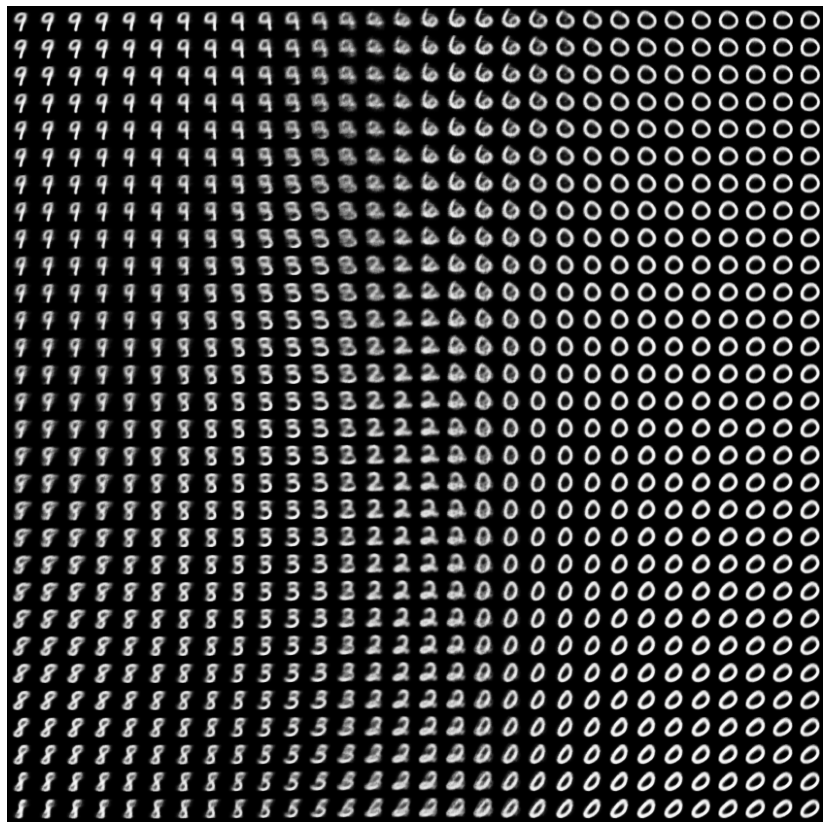

In [8]:
# Sampling a grid of images from the 2D latent space
import matplotlib.pyplot as plt

# Display a 30x30 grid of digits (900 total):
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Sample points linearly on a 2D grid:
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

# Iterate over grid locations:
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # For each location, sample a digit and add it to the figure:
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")